In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fluid_module import canonical_fibonacci_lattice, oseen_tensor, oseen_tensor_on_points, force_on_sphere, discretized_sphere, field_cartesian

In [2]:
# Parameters
N_sphere = 2500
N_point = 20
squirmer_radius = 1
point_radius = 2.5 * squirmer_radius
max_mode = 2
regularization_offset = 0.0001
viscosity = 1

# Modes
B = np.zeros((3, 3))
B_tilde = np.zeros_like(B)
C = np.zeros_like(B)
C_tilde = np.zeros_like(B)
#B[0,1] = 1
B_tilde[1, 2] = 1

# Points outside sphere
grid_vals = np.linspace(-point_radius, point_radius, N_point) + 0.1
x_point = np.zeros_like(grid_vals)
y_point = 1 * grid_vals
z_point = 1 * grid_vals
X, Y, Z = np.meshgrid(x_point, y_point, z_point)
R = np.sqrt(X.flatten() ** 2 + Y.flatten() ** 2 + Z.flatten() ** 2)

# Do the calculations
x_sphere, y_sphere, z_sphere, theta, phi, area = canonical_fibonacci_lattice(N_sphere, squirmer_radius)

A_oseen = oseen_tensor_on_points(x_sphere, y_sphere, z_sphere, 
                                 X.flatten(), Y.flatten(), Z.flatten(), 
                                 regularization_offset=regularization_offset, dA=area, viscosity=viscosity)
#A_oseen /= 2
forces, u_surface = force_on_sphere(N_sphere, distance_squirmer=R, max_mode=max_mode, theta=theta, phi=phi, squirmer_radius=squirmer_radius, 
                            B=B, B_tilde=B_tilde, C=C, C_tilde=C_tilde, regularization_offset=regularization_offset,
                            viscosity=viscosity, lab_frame=True)
forces = np.expand_dims(forces, axis=1)
u_sphere = A_oseen @ forces

In [3]:
def oseen_point23(x_sphere, y_sphere, z_sphere, x_points, y_points, z_points, epsilon, dA, viscosity):
    oseen_factor = dA / (8 * np.pi * viscosity)
    
    dx = x_points[:, None] - x_sphere[None, :]
    dy = y_points[:, None] - y_sphere[None, :]
    dz = z_points[:, None] - z_sphere[None, :]
    r = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    r_epsilon_cubed = np.sqrt(r ** 2 + epsilon ** 2) ** 3
    
    S = (dz * dy) / r_epsilon_cubed
    return S * oseen_factor

In [4]:
oseen_tensor_on_points(x_sphere, y_sphere, z_sphere, 
                       X.flatten(), Y.flatten(), Z.flatten(), 
                       regularization_offset=regularization_offset, dA=area, viscosity=viscosity)[N_point**3:2*N_point**3, 2*N_sphere:3*N_sphere]

array([[2.26422429e-05, 2.26430947e-05, 2.26451504e-05, ...,
        3.03429955e-05, 3.19803079e-05, 3.12321516e-05],
       [2.44383714e-05, 2.44761782e-05, 2.43711466e-05, ...,
        2.80804622e-05, 2.98565280e-05, 2.90337884e-05],
       [2.62819491e-05, 2.63676765e-05, 2.61238874e-05, ...,
        2.41530542e-05, 2.58900100e-05, 2.50729987e-05],
       ...,
       [2.50847635e-05, 2.46008012e-05, 2.60834582e-05, ...,
        2.46481368e-05, 2.44031649e-05, 2.45099429e-05],
       [2.78188497e-05, 2.73421250e-05, 2.87780157e-05, ...,
        2.29997935e-05, 2.28776257e-05, 2.29300463e-05],
       [2.92390089e-05, 2.88053663e-05, 3.00912898e-05, ...,
        2.13950284e-05, 2.13698306e-05, 2.13792953e-05]])

In [5]:
oseen_point23(x_sphere, y_sphere, z_sphere, 
              X.flatten(), Y.flatten(), Z.flatten(),
              epsilon=regularization_offset, dA=area, viscosity=viscosity);

In [6]:
# The known velocity field
y_field = 1 * y_point
z_field = 1 * z_point
Z_field, Y_field = np.meshgrid(z_field, y_field)
R_field = np.sqrt(Z_field**2 + Y_field**2)
Theta = np.arctan2(Y_field, Z_field) + np.pi
Phi = np.ones(np.shape(Theta)) * np.pi/2

ux_field, uy_field, uz_field = field_cartesian(max_mode, R_field.flatten(), Theta.flatten(), Phi.flatten(), 
                                               squirmer_radius, B, B_tilde, C, C_tilde, lab_frame=True )
ux_field = ux_field.reshape(np.shape(R_field))
uy_field = uy_field.reshape(np.shape(R_field))
uz_field = uz_field.reshape(np.shape(R_field))
print(uy_field.reshape(np.shape(R_field)))
mask_squirmer = R_field < squirmer_radius
ux_field[mask_squirmer] = 0
uy_field[mask_squirmer] = 0
uz_field[mask_squirmer] = 0

[[-2.52236713e-01 -2.89822111e-01 -3.25927605e-01 -3.55298095e-01
  -3.70517453e-01 -3.62745921e-01 -3.23794095e-01 -2.49447829e-01
  -1.42845921e-01 -1.57943267e-02  1.13607214e-01  2.26499960e-01
   3.09203044e-01  3.56493799e-01  3.71089917e-01  3.60561261e-01
   3.33836093e-01  2.98783889e-01  2.61190104e-01  2.24725250e-01]
 [-2.62398890e-01 -3.10281030e-01 -3.59940370e-01 -4.05400528e-01
  -4.36950905e-01 -4.41494737e-01 -4.05230323e-01 -3.19130941e-01
  -1.85390088e-01 -2.06140518e-02  1.47763371e-01  2.90990364e-01
   3.89257382e-01  4.36982494e-01  4.41044837e-01  4.14688839e-01
   3.71534732e-01  3.22205911e-01  2.73527217e-01  2.29139773e-01]
 [-2.65196560e-01 -3.23605006e-01 -3.88640750e-01 -4.54268063e-01
  -5.08533124e-01 -5.32737204e-01 -5.04486660e-01 -4.06703010e-01
  -2.39629402e-01 -2.67839286e-02  1.91382724e-01  3.72420178e-01
   4.87719748e-01  5.31563057e-01  5.17912274e-01  4.68925314e-01
   4.04676155e-01  3.38756553e-01  2.78449651e-01  2.26641378e-01]
 [-2.58

In [7]:
u_y = u_sphere[N_point**3:2*N_point**3]
u_z = u_sphere[2*N_point**3:3*N_point**3]

u_y = u_y.reshape(N_point, N_point, N_point)
u_z = u_z.reshape(N_point, N_point, N_point)

u_y = u_y[:, 0, :]
u_z = u_z[:, 0, :]

Y_plot = Y[:, 0, :]
Z_plot = Z[:, 0, :]


In [8]:
u_y

array([[ 1.26437454e-03,  1.88269106e-03,  2.56982890e-03,
         3.26179085e-03,  3.84498023e-03,  4.15607297e-03,
         4.01097692e-03,  3.27331613e-03,  1.94470281e-03,
         2.20446732e-04, -1.55024111e-03, -2.99897824e-03,
        -3.88562449e-03, -4.16435188e-03, -3.94652832e-03,
        -3.41245154e-03, -2.73449965e-03, -2.03897845e-03,
        -1.40084924e-03, -8.54660421e-04],
       [ 7.48739483e-04,  1.44500235e-03,  2.28541937e-03,
         3.21915374e-03,  4.12134505e-03,  4.77144485e-03,
         4.87290523e-03,  4.15332964e-03,  2.53799489e-03,
         2.90349006e-04, -2.03298420e-03, -3.83776018e-03,
        -4.77690446e-03, -4.85207865e-03, -4.30538238e-03,
        -3.44021099e-03, -2.49961179e-03, -1.63026546e-03,
        -8.97978228e-04, -3.17329397e-04],
       [-4.27049275e-05,  6.68211566e-04,  1.61246345e-03,
         2.77817883e-03,  4.05993286e-03,  5.19451028e-03,
         5.73791715e-03,  5.18609988e-03,  3.28987078e-03,
         3.81299346e-04, -2.6

# Shape investigation
print("N_sphere = ", N_sphere)
print("N_sphere**3 = ", N_sphere ** 3)
print("N_point =", N_point)
print("N_point**3 =", N_point ** 3)

print("")
print("u_y shape = ", np.shape(u_y))
print("Y shape = ", np.shape(Y))
print("Y_field shape = ", np.shape(Y_field))
print("")
print("Y_plot shape=", np.shape(Y_plot))

print("")
print("Oseen =", np.shape(A_oseen))
print("force =", np.shape(forces))

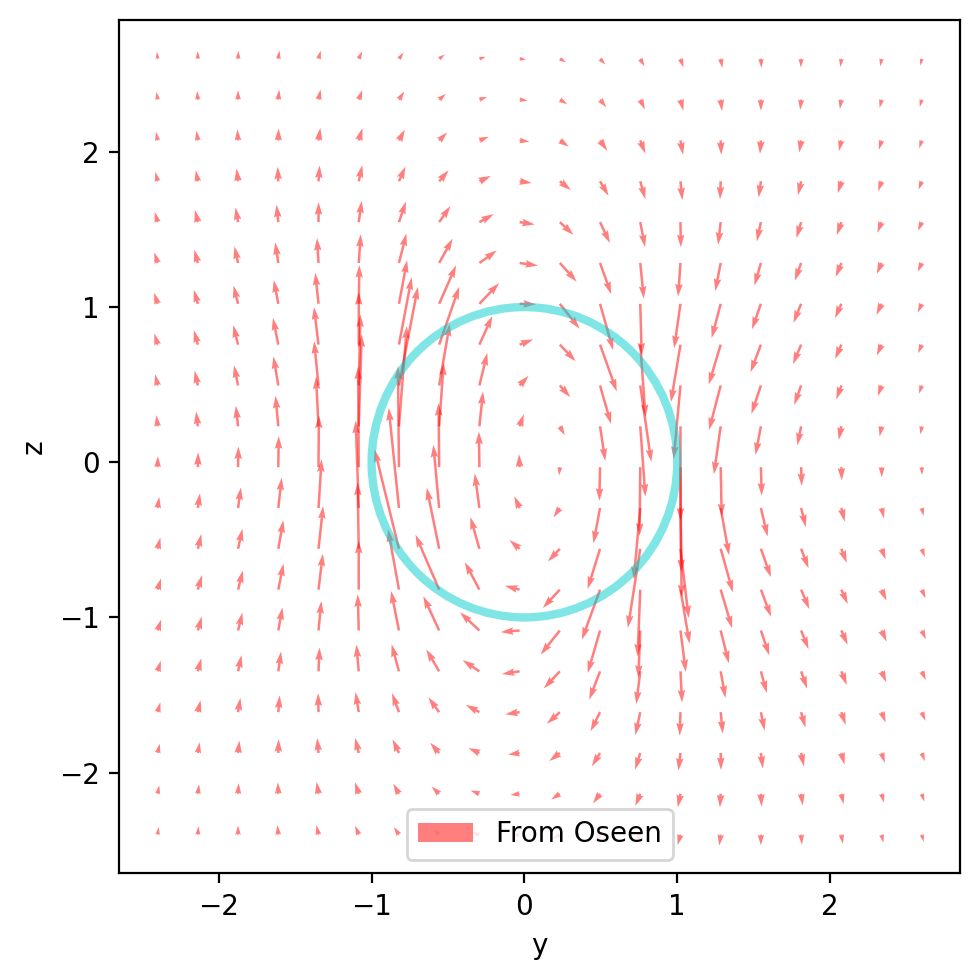

In [9]:
from matplotlib.patches import Circle
fig, ax = plt.subplots(dpi=200, figsize=(5, 5))
circle = Circle((0, 0), radius=squirmer_radius, facecolor="none", edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
ax.add_patch(circle)

#ax.quiver(Y_field, Z_field, uy_field, uz_field, color="blue", label="Original Field")
ax.quiver(Y_plot, Z_plot, u_y, u_z, color="red", alpha=0.5, label="From Oseen")
ax.set(xlabel="y", ylabel="z")
ax.legend()
fig.tight_layout()

In [9]:
N = 2
r = 3
a = 1
B = np.random.uniform(size=(N+1, N+1))
B_tilde = B / 2
C = B / 3
C_tilde = B / 4
theta = 0
#vals, diff = lpmn(N, N, np.cos(theta))
#print(diff)
#u_r, u_theta = field_polar(N, r, theta, a, B, B_tilde, C, C_tilde)
#print(u_r, u_theta)
x, y, z,_ = discretized_sphere(N=1000, radius=1)
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection="3d")
ax.scatter(x, y, z)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()
plt.close()

x_can, y_can, z_can, _ = canonical_fibonacci_lattice(N=1000, radius=1)
fig_1 = plt.figure(dpi=200)
ax_1 = fig_1.add_subplot(projection="3d")
ax_1.scatter(x_can, y_can, z_can)
ax_1.set_xlabel("x")
ax_1.set_ylabel("y")
ax_1.set_zlabel("z")
plt.show()
plt.close()


ValueError: too many values to unpack (expected 4)

In [ ]:
def Oseen(x, y, z, zeta_x, zeta_y, zeta_z, epsilon):
    """
    arbitary point: x,y,z 
    singular point: zeta_x, zeta_y, zeta_z,
    return the oseen matrix/tensor S which is 3x3 big
    The oseen tensor has NOT been integrated
    """
    S = np.ones((3,3))
    r1 = x - zeta_x  # distance between an arbitary point and the a singular point 
    r2 = y - zeta_y
    r3 = z - zeta_z
    
    r = np.sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    r_epsilon = np.sqrt(r ** 2 + epsilon ** 2)
        
    S[0, 0] = (r ** 2 + 2 * epsilon ** 2 + r1 ** 2) / r_epsilon ** 3
    S[1, 1] = (r ** 2 + 2 * epsilon ** 2 + r2 ** 2) / r_epsilon ** 3
    S[2, 2] = (r ** 2 + 2 * epsilon ** 2 + r3 ** 2) / r_epsilon ** 3
    S[0, 1] = S[1, 0] = r1 * r2 / r_epsilon ** 3
    S[0, 2] = S[2, 0] = r1 * r3 / r_epsilon ** 3
    S[1, 2] = S[2, 1] = r1 * r3 / r_epsilon ** 3
    
    return S

In [ ]:
N = 4
A = np.ones((3*N ,3*N))
B = np.ones((3*N))
print(np.shape( B))
A[0:3, 0:3] = 10 
A[0:3 , 3 :2*3 ] = 12
A[0:3 , 2*3 :3*3 ] = 33
A[0:3 , 3*3 :4*3 ] = 4

A[3:2*3,  0:3] = 58
A[2*3:3*3,  0:3] = 0
A[3*3:4*3, 0:3] = 66

A[3*3:4*3, 3*3:4*3] = 100

print(A)
print(np.shape(A @ B))
A @ B

(12,)
[[ 10.  10.  10.  12.  12.  12.  33.  33.  33.   4.   4.   4.]
 [ 10.  10.  10.  12.  12.  12.  33.  33.  33.   4.   4.   4.]
 [ 10.  10.  10.  12.  12.  12.  33.  33.  33.   4.   4.   4.]
 [ 58.  58.  58.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 58.  58.  58.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 58.  58.  58.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [  0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
 [ 66.  66.  66.   1.   1.   1.   1.   1.   1. 100. 100. 100.]
 [ 66.  66.  66.   1.   1.   1.   1.   1.   1. 100. 100. 100.]
 [ 66.  66.  66.   1.   1.   1.   1.   1.   1. 100. 100. 100.]]
(12,)


array([177., 177., 177., 183., 183., 183.,   9.,   9.,   9., 504., 504.,
       504.])

In [ ]:
x, y, z, da = discretized_sphere(50 , 1)

ux, uy, uz = velocity(x, y,z, 1)

U = np.array((ux, uy, uz)).flatten()
print(np.shape(x))

(50,)


In [ ]:
A = oseen_tensor(x, y, z, 0.01, da, 1)
np.shape(A)


(150, 150)

In [ ]:
F =np.linalg.solve(A, U)